In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import *
from resnet_v2 import Resnet4Channel

In [3]:
gpu_device = 0

defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
path = Path('/home/haider/data/human_protein_atlas/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [7]:
# src.train.x.create_func = open_4_channel
# src.train.x.open = open_4_channel

src.train.x.create_func = open_RGB_channel
src.train.x.open = open_RGB_channel

In [8]:
# src.valid.x.create_func = open_4_channel
# src.valid.x.open = open_4_channel

src.valid.x.create_func = open_RGB_channel
src.valid.x.open = open_RGB_channel

In [9]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [10]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [11]:
test_fnames[:5]

[PosixPath('/home/haider/data/human_protein_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [12]:
src.add_test(test_fnames, label='0');

In [13]:
# src.test.x.create_func = open_4_channel
# src.test.x.open = open_4_channel

src.test.x.create_func = open_RGB_channel
src.test.x.open = open_RGB_channel

In [14]:
# protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
protein_stats = ([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])

In [15]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [16]:
NUM_WORKERS = 8
BS = 14 # 64//4

In [17]:
data = (src.transform((trn_tfms, _), size=512)
        .databunch(bs=BS, num_workers=NUM_WORKERS).normalize(protein_stats))

#        .normalize(imagenet_stats)

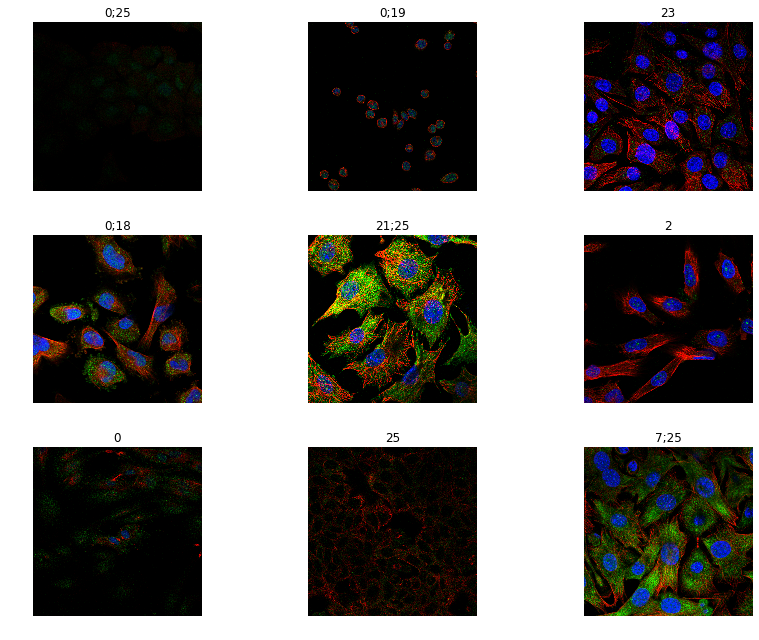

In [18]:
data.show_batch(rows=3, figsize=(12,9))

In [19]:
# def resnet50(pretrained):
#     return Resnet4Channel(encoder_depth=50)

In [20]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
# def _resnet_split(m): 
#     # import pdb; pdb.set_trace()  ; m[0] returns the body ; m[0][6] returns the 7th block of the body ; m[1] returns the head; 
#     # so it seems this function specifies the points that divides the 3 groups for the differential learning rates
#     return (m[0][6],m[1])

In [21]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [22]:
learn = create_cnn(
    data,
    models.resnet50,
    cut=-2,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [23]:
learn.loss_func

<function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)>

In [24]:
# learn = create_cnn(
#     data,
#     resnet50,
#     cut=-2,
#     split_on=_resnet_split,
#     loss_func=F.binary_cross_entropy_with_logits,
#     path=path,    
#     metrics=[f1_score], 
# ).mixup()

In [25]:
# learn.loss_func

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


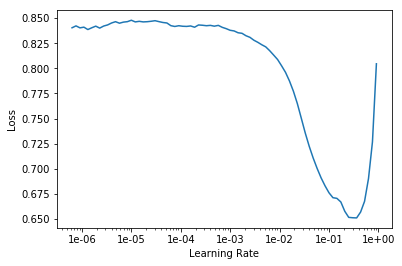

In [27]:
learn.recorder.plot()

In [28]:
lr = 3e-2/4

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.133020,0.119083,0.582832
2,0.115333,0.106017,0.640218
3,0.106658,0.296952,0.666546
4,0.102057,0.091325,0.688690
5,0.095582,0.091331,0.690958


In [30]:
learn.save('stage-1-rn50_sz512_RGB')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


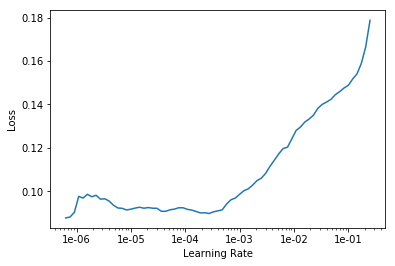

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(15, slice(3e-5/4, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.096844,0.092929,0.692358
2,0.102184,0.092247,0.688627
3,0.099969,0.096578,0.670202
4,0.096140,0.092686,0.679202
5,0.098329,0.087251,0.707879
6,0.089010,0.088147,0.721818
7,0.090055,0.083251,0.718686
8,0.088191,0.080328,0.728016
9,0.083177,0.088066,0.729292
10,0.081499,0.086093,0.738727


In [35]:
learn.save('stage-1-rn50_sz512_RGB')

In [36]:
preds,y = learn.get_preds(DatasetType.Valid)
# y = to_np(y)
# preds = np.stack(preds, axis=-1)
# pred = preds.mean(axis=-1)  # This need when in fastai0.7 used TTA
pred = preds

## Iafoss thresholds and other tweaking methods below

In [118]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
# Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. 
# The code below does it automatically.

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
#     preds = to_np(preds)
    preds = sigmoid_np(d*(preds - th))
#     targs = to_np(targs)
#     targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0, wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [119]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [120]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th[:, None], average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

TypeError: sub(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [117]:
%debug


> <ipython-input-116-3f10e2ec51e8>(3)<module>()
      1 th = fit_val(pred,y)
      2 print('Thresholds: ',th)
----> 3 print('F1 macro: ',f1_score(y, pred>th[:, None], average='macro'))
      4 print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
      5 print('F1 micro: ',f1_score(y, pred>th, average='micro'))



ipdb>  u


*** Oldest frame


ipdb>  d


*** Newest frame


ipdb>  exit


Using CV to prevent overfitting the thresholds:

In [ ]:
# This function is trying to minimize (F1-1)^2 + wd^2*th^2. So, you are trying to get F1 close to 1. 
# while if something goes wrong, like there are just a few data points, thresholds do not go far away from 0.0. 
# Also, I'm using a soft version of F1 to have stable gradient in least square minimization.

from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Plot the distribution of lables to see how the model performs. Be aware about log scale.

In [ ]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

**Submission**

In [ ]:
preds_t,y_t = learn.get_preds(DatasetType.Test)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [ ]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

Save predictions for thresholds calculated based on the validation set and constant value 0.0:

In [ ]:
name = 'initialize_weight'

save_pred(pred_t,th,path/'subs'/f'{name}_v_th.csv')
save_pred(pred_t,0.0,path/'subs'/f'{name}_0_th.csv')

Similar to validation, additional adjustment may be done based on the public LB probing results (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68678) to predict approximately the same fraction of images of a particular class as expected from the public LB (I replaced 0 by 0.01 since there may be a rounding error leading to 0). Automatic fitting the thresholds based on the public LB statistics:

Haider Update: Turned out it is very similar to the fractions of the train set, so don't think it is useful

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,path/'subs'/f'{name}_f_th.csv')

Try using the threshold from validation set for classes not present in the public LB:

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,path/'subs'/f'{name}_c_th.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,path/'subs'/f'{name}_t_th.csv')

Brian's single threshold method

In [135]:
y

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
# !conda install -c anaconda scikit-learn -y

Solving environment: done

## Package Plan ##

  environment location: /home/haider/anaconda3/envs/fastai-v1

  added / updated specs: 
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    scikit-learn-0.20.1        |   py37h4989274_0         5.7 MB  anaconda
    ca-certificates-2018.03.07 |                0         124 KB  anaconda
    certifi-2018.10.15         |           py37_0         138 KB  anaconda
    ------------------------------------------------------------
                                           Total:        10.9 MB

The following NEW packages will be INSTALLED:

    scikit-learn:    0.20.1-py37h4989274_0 anaconda

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0                   --> 2018.03.07-0      anaconda
    openssl:         1.1.1a-h7b6447c_0      

In [39]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

# preds_y = model.predict(valid_x) # in his code mine is : preds_y -> preds; valid_y -> y

thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(y > 0.5, preds > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))



Threshold 0.0000, F1: 0.0992
Threshold 0.0007, F1: 0.1459
Threshold 0.0013, F1: 0.1766
Threshold 0.0020, F1: 0.1988
Threshold 0.0027, F1: 0.2183
Threshold 0.0033, F1: 0.2371
Threshold 0.0040, F1: 0.2516
Threshold 0.0047, F1: 0.2638
Threshold 0.0053, F1: 0.2787
Threshold 0.0060, F1: 0.2899
Threshold 0.0067, F1: 0.2998
Threshold 0.0073, F1: 0.3087
Threshold 0.0080, F1: 0.3177
Threshold 0.0087, F1: 0.3247
Threshold 0.0093, F1: 0.3318
Threshold 0.0100, F1: 0.3414
Threshold 0.0107, F1: 0.3486
Threshold 0.0113, F1: 0.3560
Threshold 0.0120, F1: 0.3628
Threshold 0.0127, F1: 0.3751
Threshold 0.0133, F1: 0.3834
Threshold 0.0140, F1: 0.3898
Threshold 0.0147, F1: 0.3953
Threshold 0.0153, F1: 0.4017
Threshold 0.0160, F1: 0.4065
Threshold 0.0167, F1: 0.4118
Threshold 0.0173, F1: 0.4167
Threshold 0.0180, F1: 0.4201
Threshold 0.0187, F1: 0.4246
Threshold 0.0193, F1: 0.4288
Threshold 0.0200, F1: 0.4331
Threshold 0.0207, F1: 0.4371
Threshold 0.0213, F1: 0.4428
Threshold 0.0220, F1: 0.4468
Threshold 0.02

/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold 0.1234, F1: 0.6180
Threshold 0.1241, F1: 0.6184
Threshold 0.1247, F1: 0.6190
Threshold 0.1254, F1: 0.6198
Threshold 0.1261, F1: 0.6202
Threshold 0.1268, F1: 0.6208
Threshold 0.1274, F1: 0.6213
Threshold 0.1281, F1: 0.6218
Threshold 0.1288, F1: 0.6220
Threshold 0.1294, F1: 0.6224
Threshold 0.1301, F1: 0.6226
Threshold 0.1308, F1: 0.6229
Threshold 0.1314, F1: 0.6237
Threshold 0.1321, F1: 0.6241
Threshold 0.1328, F1: 0.6246
Threshold 0.1334, F1: 0.6243
Threshold 0.1341, F1: 0.6242
Threshold 0.1348, F1: 0.6243
Threshold 0.1354, F1: 0.6248
Threshold 0.1361, F1: 0.6255
Threshold 0.1368, F1: 0.6262
Threshold 0.1374, F1: 0.6263
Threshold 0.1381, F1: 0.6262
Threshold 0.1388, F1: 0.6259
Threshold 0.1394, F1: 0.6260
Threshold 0.1401, F1: 0.6258
Threshold 0.1408, F1: 0.6259
Threshold 0.1414, F1: 0.6268
Threshold 0.1421, F1: 0.6272
Threshold 0.1428, F1: 0.6278
Threshold 0.1434, F1: 0.6283
Threshold 0.1441, F1: 0.6286
Threshold 0.1448, F1: 0.6291
Threshold 0.1454, F1: 0.6295
Threshold 0.14

## Brian's method to calculate thresholds

In [40]:
preds_np= to_np(preds)

thresholds = np.linspace(0, 1, 100)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        # max_val = np.max(preds)
        # import pdb; pdb.set_trace()
        val_predict = (preds_np > test_threshold)
        score = f1_score(y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]
print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

Threshold[0] 0.353535, F1: 0.608094
Threshold[1] 0.292929, F1: 0.608754
Threshold[2] 0.323232, F1: 0.609086
Threshold[3] 0.303030, F1: 0.609872
Threshold[4] 0.404040, F1: 0.610168
Threshold[5] 0.515152, F1: 0.610172
Threshold[6] 0.353535, F1: 0.611103
Threshold[7] 0.363636, F1: 0.611287
Threshold[8] 0.252525, F1: 0.622619
Threshold[9] 0.202020, F1: 0.626020
Threshold[10] 0.111111, F1: 0.640760
Threshold[11] 0.222222, F1: 0.642122
Threshold[12] 0.363636, F1: 0.642896
Threshold[13] 0.373737, F1: 0.643698
Threshold[14] 0.242424, F1: 0.644038
Threshold[15] 0.030303, F1: 0.653315
Threshold[16] 0.181818, F1: 0.654062
Threshold[17] 0.242424, F1: 0.661280
Threshold[18] 0.313131, F1: 0.663485
Threshold[19] 0.272727, F1: 0.665532
Threshold[20] 0.151515, F1: 0.672736
Threshold[21] 0.232323, F1: 0.675404
Threshold[22] 0.323232, F1: 0.676179
Threshold[23] 0.424242, F1: 0.676300
Threshold[24] 0.464646, F1: 0.676629
Threshold[25] 0.333333, F1: 0.677663
Threshold[26] 0.353535, F1: 0.678174
Threshold[2

In [41]:
best_threshold

array([0.353535, 0.292929, 0.323232, 0.30303 , 0.40404 , 0.515152, 0.353535, 0.363636, 0.252525, 0.20202 , 0.111111,
       0.222222, 0.363636, 0.373737, 0.242424, 0.030303, 0.181818, 0.242424, 0.313131, 0.272727, 0.151515, 0.232323,
       0.323232, 0.424242, 0.464646, 0.333333, 0.353535, 0.020202])

**Submission**

In [42]:
name = 'resnet50-512'

preds_t,_ = learn.get_preds(DatasetType.Test)
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>best_threshold)[0]])) for row in np.array(preds_t)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [ ]:
# Horton's preds with fixed thresholds:

In [34]:
# preds,_ = learn.get_preds(DatasetType.Test)

In [54]:
## The chosen thresholds for all labels is set arbitrarly to 0.2

# name = 'baseline'

# pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
# df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [155]:
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23


In [44]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 685kB/s 
    100% |████████████████████████████████| 133kB 2.2MB/s 
    100% |████████████████████████████████| 245kB 2.3MB/s 
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /home/haider/.cache/pip/wheels/5a/2d/0c/9fc539e558586b9ed9127916a7f4e620163c24cc97460b1188
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /home/haider/.cache/pip/wheels/2b/9e/c8/14a18ab55d8f144384de8186a3df8401dcc9264936f71d470f
Successfully built kaggle python-slugify
fastai 1.0.39 requires nvidia-ml-py3, which is not installed.
fastai 1.0.39 requires Pillow, which is not installed.
  Found existing installation: urllib3 1.24.1
    Uninstalling urllib3-1.24.1:
      Successfully uninstalled urllib3-1.24.1


In [45]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/subs/{name}.csv -m "resnet50-4th channel 0 init-512"

[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 274, in update_class
    old_obj = getattr(old, key)
  File "/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/urllib3/packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of 

100%|████████████████████████████████████████| 470k/470k [00:06<00:00, 72.8kB/s]
Successfully submitted to Human Protein Atlas Image Classification